# EDA

**Cryptocurrency Market Data Analytics**

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 20)

# Nuestro JSON esta preparado de 1 JSON por linea, por esta razon se pone lines=True.
# Además se tiene que poner convert_dates=False para que no convierta 'dates' a datetime porque lo hace de forma incorrecta.
df = pd.read_json("datasets/raw_coins_data.json", lines=True, convert_dates=False)

df.head()

,id,symbol,name,date,current_price,market_cap,total_volume,facebook_likes,twitter_followers,reddit_average_posts_48h,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,alexa_rank,bing_matches,additions,deletions
0,bitcoin,btc,Bitcoin,01-01-2021,29022.418395,5.394380e+11,4.350352e+10,NaN,74537.0,6.250,...,3624.0,5885.0,5288.0,8185.0,706.0,298.0,NaN,NaN,1819.0,-1561.0
1,bitcoin,btc,Bitcoin,02-01-2021,29352.126792,5.455933e+11,3.408972e+10,NaN,74635.0,7.909,...,3624.0,5889.0,5291.0,8188.0,706.0,280.0,NaN,NaN,1862.0,-1625.0
2,bitcoin,btc,Bitcoin,03-01-2021,32163.824935,5.978877e+11,5.727344e+10,NaN,74741.0,7.500,...,3624.0,5889.0,5291.0,8188.0,706.0,277.0,NaN,NaN,1862.0,-1625.0
3,bitcoin,btc,Bitcoin,04-01-2021,33008.226203,6.136169e+11,1.788941e+11,NaN,74852.0,6.273,...,3625.0,5892.0,5294.0,8193.0,706.0,279.0,NaN,NaN,1230.0,-1291.0
4,bitcoin,btc,Bitcoin,05-01-2021,31515.575967,5.857263e+11,7.465717e+10,NaN,74907.0,6.333,...,3634.0,5893.0,5300.0,8199.0,706.0,272.0,NaN,NaN,1277.0,-1361.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9420 entries, 0 to 9419
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           9420 non-null   object 
 1   symbol                       9420 non-null   object 
 2   name                         9420 non-null   object 
 3   date                         9420 non-null   object 
 4   current_price                9420 non-null   float64
 5   market_cap                   9420 non-null   float64
 6   total_volume                 9420 non-null   float64
 7   facebook_likes               0 non-null      float64
 8   twitter_followers            7828 non-null   float64
 9   reddit_average_posts_48h     9420 non-null   float64
 10  reddit_average_comments_48h  9420 non-null   float64
 11  reddit_subscribers           6608 non-null   float64
 12  reddit_accounts_active_48h   6608 non-null   float64
 13  forks             

## Columnas cualitativas

In [47]:
df.select_dtypes(include=['object']).columns

Index(['id', 'symbol', 'name', 'date'], dtype='object')

Estas son las "4" columnas cualitativas. Aunque en realidad `date` la vamos a convertir a fecha mas adelante así que nos quedan `id`, `symbol` y `name`.

Esas tres estan relacionadas con el nombre e identificacion de cada una de las monedas.

Segun la API de CoinGecko, `id` es la unica que nos asegura que nunca se va a repetir asi que preferimos quedarnos con esa y descartar el resto ya que no va a ser necesaria para nuestro analisis.

In [48]:
df = df.drop(columns=['symbol', 'name'])

Nos quedamos solo con id, vamos a asegurarnos que no tenga ningun NaN y guardar las categorias unicas que corresponden a los nombres de las monedas.

In [49]:
print('Cantidad NaNs en id:', df['id'].isna().sum())
coinIds = df['id'].unique()
print('Ids de monedas:\n', coinIds)

Cantidad NaNs en id: 0
Ids de monedas:
 ['bitcoin' 'ethereum' 'tether' 'binancecoin' 'ripple' 'usd-coin'
 'staked-ether' 'dogecoin' 'cardano' 'solana']


### Date
Convertir 'date' a datetime leyendo el formato correcto.

In [50]:
df['date'].head()

0    01-01-2021
1    02-01-2021
2    03-01-2021
3    04-01-2021
4    05-01-2021
Name: date, dtype: object

In [51]:
df['date'] = pd.to_datetime(df['date'], format="%d-%m-%Y")

In [52]:
df['date'].head()

0   2021-01-01
1   2021-01-02
2   2021-01-03
3   2021-01-04
4   2021-01-05
Name: date, dtype: datetime64[ns]

In [53]:
df['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 9420 entries, 0 to 9419
Series name: date
Non-Null Count  Dtype         
--------------  -----         
9420 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 73.7 KB


Ahora vemos que ya es datetime64 y ademas miramos que la fecha mínima es 2021-01-01 y la máxima es 2023-07-31

In [54]:
df['date'].describe()

count                   9420
mean     2022-04-16 12:00:00
min      2021-01-01 00:00:00
25%      2021-08-24 00:00:00
50%      2022-04-16 12:00:00
75%      2022-12-08 00:00:00
max      2023-07-31 00:00:00
Name: date, dtype: object

Por ultimo revisemos que no halla ningun NaN en `date`.

In [55]:
df['date'].isna().sum()

0

### Chequear filas duplicadas
Debido a como levantamos los datos no debería haber ninguna pero igual es importante revisarlo. 

In [56]:
df.duplicated().sum()

0

###  Renombrar columnas
Renombrar additions y deletions con el prefijo de code para recordar de que eran y current price en realidad es price para esa fecha.

In [57]:
df.rename({'additions': 'code_additions', 'deletions': 'code_deletions', 'current_price': 'price'}, axis=1, inplace=True)

## Ordenar
Que quede cada moneda con todos sus valores juntos.

In [58]:
df = df.sort_values(['id', 'date'], ascending = [True, True])
df.head()

,id,date,price,market_cap,total_volume,facebook_likes,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,alexa_rank,bing_matches,code_additions,code_deletions
944,binancecoin,2021-01-01,37.394591,5.507756e+09,5.404438e+08,NaN,1438180.0,7.636,42.182,83484.0,...,464.0,122.0,122.0,55.0,26.0,1.0,NaN,NaN,20.0,0.0
953,binancecoin,2021-01-02,37.907080,5.584591e+09,5.485998e+08,NaN,1442434.0,7.545,40.545,83751.0,...,464.0,122.0,122.0,55.0,26.0,1.0,NaN,NaN,20.0,0.0
962,binancecoin,2021-01-03,38.340783,5.664993e+09,6.372022e+08,NaN,1450428.0,9.818,72.091,84125.0,...,464.0,122.0,122.0,55.0,26.0,1.0,NaN,NaN,20.0,0.0
971,binancecoin,2021-01-04,41.073833,6.162622e+09,9.429626e+08,NaN,NaN,11.364,89.091,84513.0,...,464.0,122.0,122.0,55.0,26.0,1.0,NaN,NaN,20.0,0.0
980,binancecoin,2021-01-05,39.962914,5.860212e+09,9.622533e+08,NaN,1459409.0,12.167,82.917,84881.0,...,464.0,122.0,122.0,55.0,26.0,1.0,NaN,NaN,20.0,0.0


# Datos Cuantitativos mas importantes

Trajimos los datos de las 10 monedas con mejor market cap.

## `price`, `market_cap` y `total_volume`

Miremos en primera instancia estas tres columnas que son muy importantes para cada moneda.

Chequeamos que no haya ningun NaN en esos datos.

In [59]:
print('Cantidad NaNs en price:', df['price'].isna().sum())
print('Cantidad NaNs en market_cap:', df['market_cap'].isna().sum())
print('Cantidad NaNs en total_volume:', df['total_volume'].isna().sum())

Cantidad NaNs en price: 0
Cantidad NaNs en market_cap: 0
Cantidad NaNs en total_volume: 0


Separar precios para cada moneda para poder tenere algunso valores estadisticos de cada una de ellas.

In [60]:
df.groupby(by=['id'])[['price', 'market_cap', 'total_volume']].agg({'price':['mean', 'min', 'max', 'std'],
                                                                    'market_cap':['mean', 'min', 'max', 'std'],
                                                                    'total_volume':['mean', 'min', 'max', 'std']})

price                                             
                      mean           min           max           std   
id                                                                     
binancecoin     337.974744     37.394591    675.098974    120.927550  \
bitcoin       35218.079667  15742.444336  67617.015545  13284.077630   
cardano           0.909147      0.175679      2.967075      0.646694   
dogecoin          0.134661      0.004707      0.681842      0.099663   
ethereum       2241.812116    730.147340   4815.004634    918.803372   
ripple            0.640631      0.220535      1.837677      0.308486   
solana           58.240824      1.515807    259.239558     58.321667   
staked-ether   2223.775559    723.531433   4775.452755    917.974576   
tether            1.000946      0.991878      1.011356      0.002036   
usd-coin          1.000655      0.965578      1.010989      0.002529   

                market_cap                                             
                      mean           min           max           std   
id                                                                     
binancecoin   5.433283e+10  5.507756e+09  1.104412e+11  2.022488e+10  \
bitcoin       6.673150e+11  3.019638e+11  1.278798e+12  2.459453e+11   
cardano       2.960471e+10  5.459442e+09  9.500373e+10  2.039455e+10   
dogecoin      1.784651e+10  5.978876e+08  8.879477e+10  1.288686e+10   
ethereum      2.660345e+11  8.329408e+10  5.716658e+11  1.081246e+11   
ripple        3.073705e+10  9.986921e+09  8.438906e+10  1.397815e+10   
solana        1.844291e+10  6.976680e+07  7.742731e+10  1.756147e+10   
staked-ether  5.999411e+09  1.212344e+07  1.539444e+10  3.901178e+09   
tether        6.737560e+10  2.093403e+10  8.389507e+10  1.460344e+10   
usd-coin      3.574697e+10  3.925840e+09  5.615979e+10  1.460804e+10   

              total_volume                                            
                      mean           min           max           std  
id                                                                    
binancecoin   1.807493e+09  1.776448e+07  2.210352e+10  1.961782e+09  
bitcoin       3.353015e+10  3.882362e+09  1.788941e+11  1.912065e+10  
cardano       1.907566e+09  8.908647e+07  1.743601e+10  2.328071e+09  
dogecoin      2.102011e+09  1.276148e+08  5.096065e+10  4.546302e+09  
ethereum      2.012762e+10  2.179799e+09  1.409065e+11  1.518356e+10  
ripple        3.749810e+09  2.316223e+08  6.246813e+10  4.716291e+09  
solana        1.265559e+09  1.711138e+07  1.614909e+10  1.343991e+09  
staked-ether  2.303485e+07  6.217976e+01  8.349852e+08  5.367116e+07  
tether        6.154257e+10  6.894278e+09  9.267677e+11  5.495640e+10  
usd-coin      3.750401e+09  8.887580e+08  1.102918e+11  4.044988e+09

**Precio**

Lo primero que podemos ver de estos datos es que el precio de `tether` y `usd-coin` son promedio 1 con una muy baja desviacion. Esto es porque son `stable coins` que manejan su precio con factores externos como el precio del dolar o de algun metal precioso.

Tambien se ve que hay gran disparidad de precios en donde la `bitcoin` es la que vale mucho mas que el resto.

**Capitalizacion de mercado**

Es dificil sacar concluciones a primera vista mas alla de que el `bitcoin` es de un orden mas grande que el resto.

**Volumen 24 horas**

A nivel de volumen transaccional el `tether`, `bitcoin` y `ethereum` son los que mas volumen mueven en promedio.

**Graficas para explorar mejor los datos.**

<Axes: xlabel='date', ylabel='total_volume'>

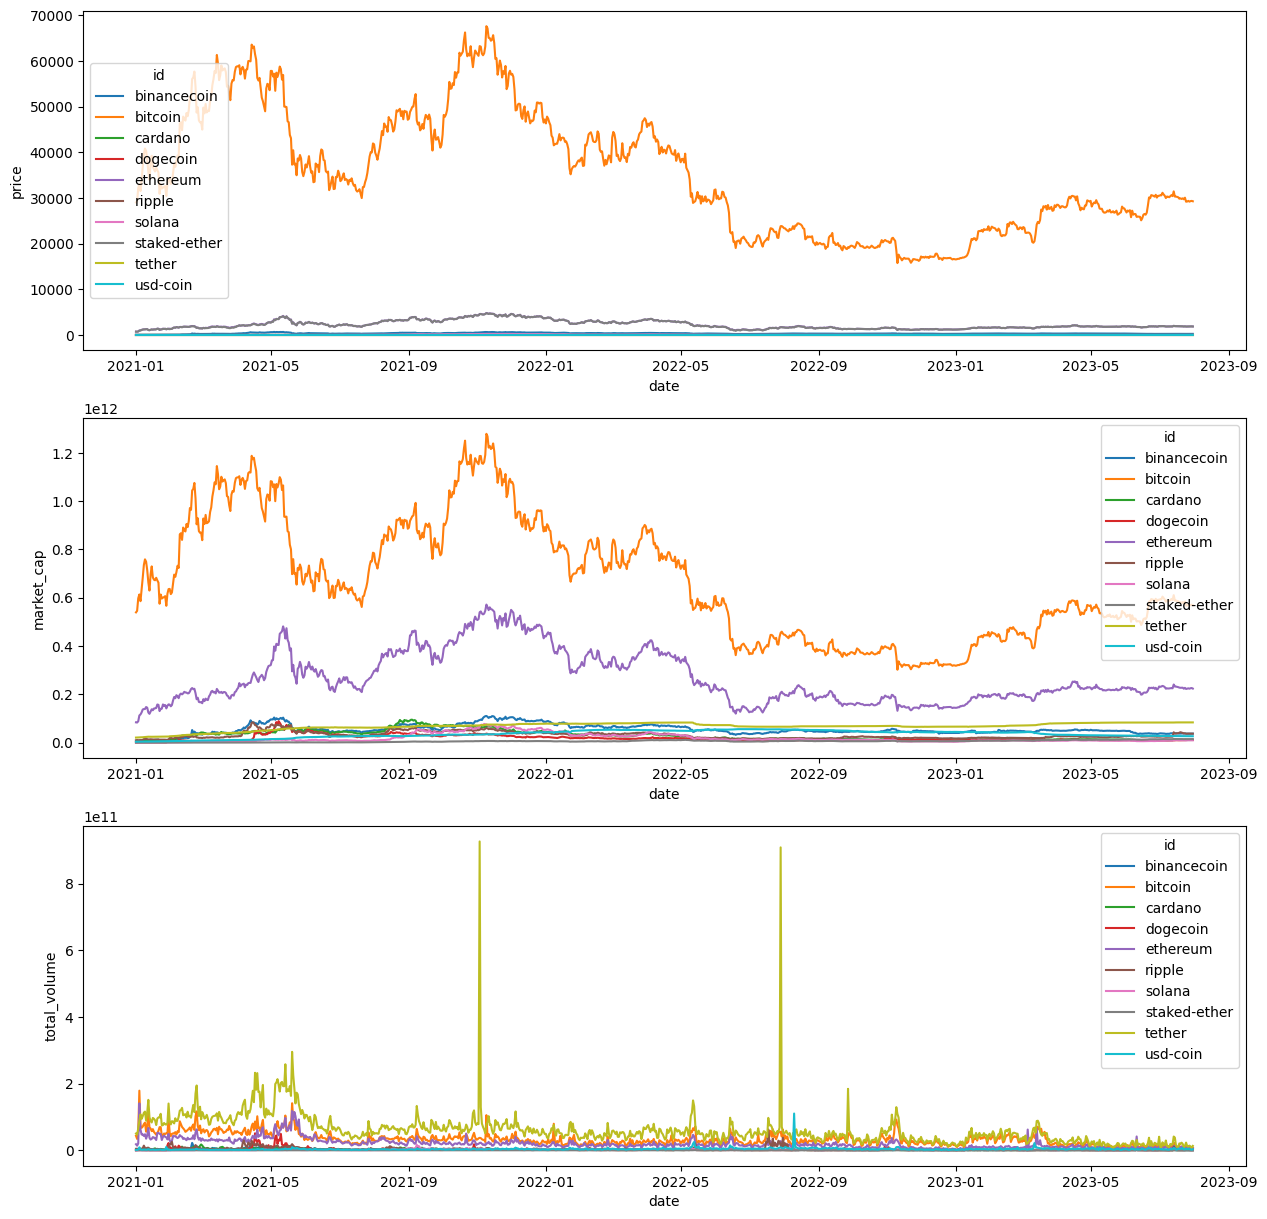

In [61]:
f, axs = plt.subplots(3, 1, figsize=(15, 15))

sns.lineplot(ax=axs[0], data=df, x='date', y='price', hue='id')
sns.lineplot(ax=axs[1], data=df, x='date', y='market_cap', hue='id')
sns.lineplot(ax=axs[2], data=df, x='date', y='total_volume', hue='id')

## Correlación de precios entre monedas

De la gráfica y los datos anteriores podemos ver que hay una gran 
Separando el precio por cada una de las monedas y haciendo un heatmap podemos ver la correlacion entre ellas.

In [62]:
# Separar precios por moneda
df_aux_prices = df.pivot(index='date', columns='id', values='price')
# Renombrar columnas
df_aux_prices.columns = [f'price_{col}' for col in df_aux_prices.columns]

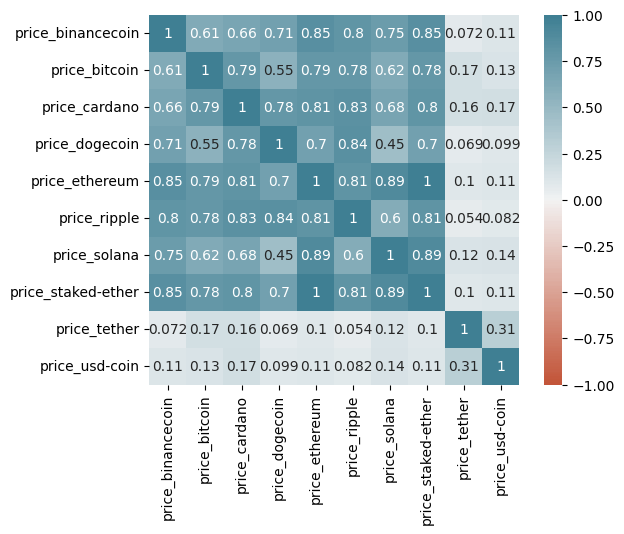

In [63]:
corr_matrix = df_aux_prices.corr()
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True)

Lo primero que llama la atencion es el Ethereum y el staked-Ethereum, que como tienen practicamente el mismo precio tienen una correlacion de 1 entre ellas.

Luego el precio de las dos criptomonedas estables (stablecoin) no tienen relacion con el resto ya que estas mantienen un precio fijo basado en alguna moneda o comodity externo.

Luego el resto de las monedas tienen una alta relacion entre ellas, la mayoria de las correlaciones estan por encima de 0.5 y muchas por encima de 0.75.

## Capitalización de Mercado

Nosotros para este estudio elegimos las 10 criptomonedas con mayor capitalización de mercado, pero igual hay diferencias en los valores que tienen entre ellas.

Como vimos anteriormente la moneda `bitcoin` tiene bastante mas capitalizacion de mercado que el resto.

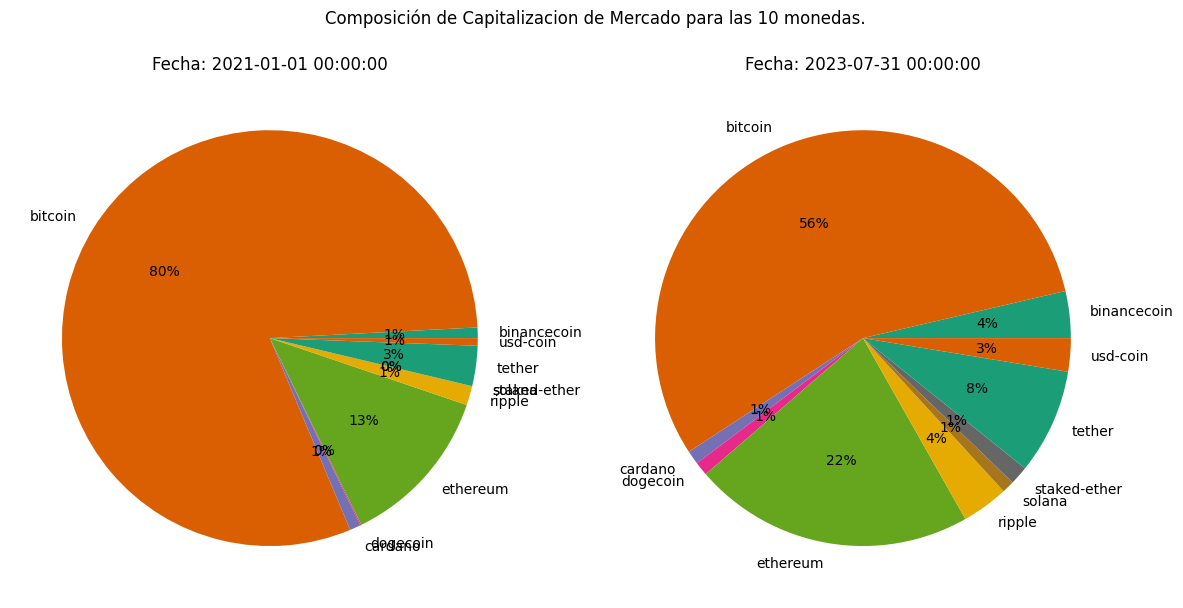

In [64]:
older_date = df['date'].min()
df_older_mkt_cap = df[df['date'] == older_date][['id', 'market_cap']]

newer_date = df['date'].max()
df_newer_mkt_cap = df[df['date'] == newer_date][['id', 'market_cap']]
  
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))

# Definir paleta colores
palette_color = sns.color_palette('Dark2')
  
# Haciendo una pie chart para saber la composicion de la capitalizacion de meracdo.
ax1.pie(df_older_mkt_cap['market_cap'], labels=df_older_mkt_cap['id'], colors=palette_color, autopct='%.0f%%')
ax1.set_title(f"Fecha: {older_date}")

ax2.pie(df_newer_mkt_cap['market_cap'], labels=df_newer_mkt_cap['id'], colors=palette_color, autopct='%.0f%%')
ax2.set_title(f"Fecha: {newer_date}")

fig.suptitle("Composición de Capitalizacion de Mercado para las 10 monedas.")
fig.tight_layout()
fig.subplots_adjust(top=1.4)

plt.show()

Vemos como a principios del 2021 habia un dominio absoluto de la `bitcoin` y ahora a mediados del 2023 por mas que sigue dominando ya empiezan a ver varias monedas con valores significativos como `ethereum` y `tether`.

In [65]:
# sns.lineplot(data=df[~df['id'].isin(['bitcoin', 'staked-ether', 'ethereum', 'binancecoin', 'solana'])], x='date', y='price', hue='id')
# sns.lineplot(data=df[df['id'].isin(['tether'])], x='date', y='price', hue='id')

## Outliers
En el volumen hay unos valores bastante extremos para la moneda `tether`, pero buscando información al respecto se confirma que esos picos de volumen sucedieron. Por esta razon no se deberia hacer nada con esos datos ya que son reales.

https://www.statista.com/statistics/1272865/tether-trade-volume/

<Axes: xlabel='date', ylabel='total_volume'>

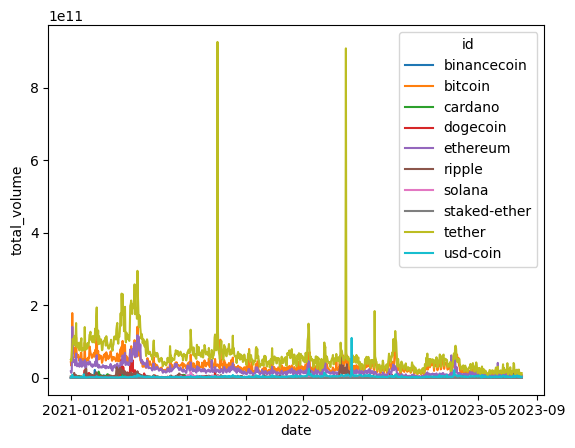

In [66]:
sns.lineplot(data=df, x='date', y='total_volume', hue='id')

---

## Redes sociales y datos Developer

La idea fue extraer mas datos mas allá de los tres valores numericos estudiados anteriormente.

### 'alexa_rank', 'bing_matches' y 'facebook_likes'
Estas tres columnas solo tienen NaNs as que son irrelevantes. Podemos dropearlas ya que no brindan ninguna informacion.

In [67]:
print('Elementos en alexa_rank:', df['alexa_rank'].unique())
print('Elementos en bing_matches:', df['bing_matches'].unique())
print('Elementos en facebook_likes:', df['facebook_likes'].unique())

Elementos en alexa_rank: [nan]
Elementos en bing_matches: [nan]
Elementos en facebook_likes: [nan]


In [68]:
df = df.drop(columns=['alexa_rank', 'bing_matches', 'facebook_likes'])

### 'twitter_followers', 'reddit_average_posts_48h' y 'reddit_average_comments_48h'

Nos vamos a quedar con `reddit_average_posts_48h` y `reddit_average_comments_48h` que no tienen NaNs y vamos a trabajar con `twitter_followers` e imputarle algunos valores faltantes.

In [69]:
print('Cantidad NaNs:')
df.isna().sum()

Cantidad NaNs:


id                                0
date                              0
price                             0
market_cap                        0
total_volume                      0
twitter_followers              1592
reddit_average_posts_48h          0
reddit_average_comments_48h       0
reddit_subscribers             2812
reddit_accounts_active_48h     2812
forks                          4115
stars                          4115
subscribers                    4115
total_issues                   4115
closed_issues                  4115
pull_requests_merged           4115
pull_request_contributors      4115
commit_count_4_weeks           4115
code_additions                 4115
code_deletions                 4115
dtype: int64

Ya que los valores que faltan de `twitter_followers` no son tantos podriamos asumir que cuando hay NaNs, los followers no cambiaron. Para esto le hacemos un fillna.

In [71]:
df['twitter_followers'] = df['twitter_followers'].fillna(method='ffill')

In [72]:
df['twitter_followers'].isna().sum()

0

<Axes: xlabel='date', ylabel='twitter_followers'>

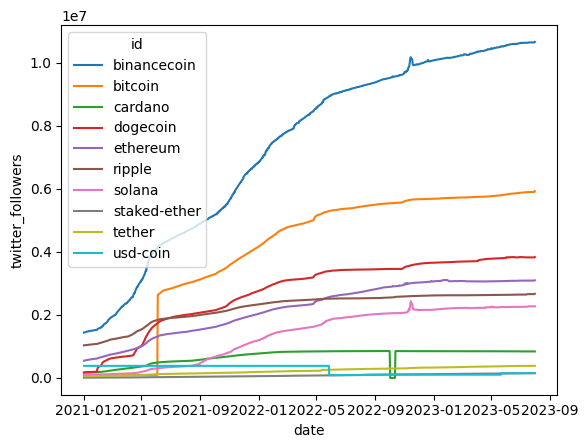

In [73]:
sns.lineplot(data=df, x='date', y='twitter_followers', hue='id')

<Axes: xlabel='date', ylabel='reddit_average_posts_48h'>

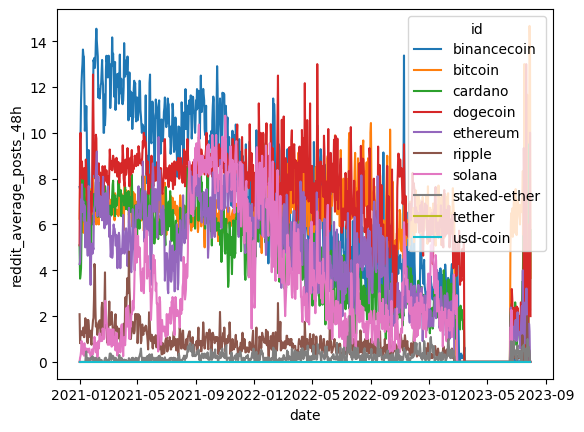

In [74]:
sns.lineplot(data=df, x='date', y='reddit_average_posts_48h', hue='id')

<Axes: xlabel='date', ylabel='reddit_average_comments_48h'>

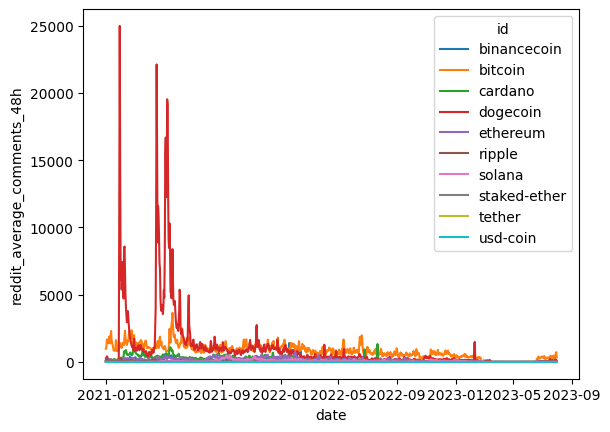

In [75]:
sns.lineplot(data=df, x='date', y='reddit_average_comments_48h', hue='id')

La `dogecoin` tiene un pico interesante en comentarios de reddit, evaluar mas adelante si eso hizo variar el precio.

# Columnas finales

Se redujeron a las columnas trabajadas con algunas numericas sobre precio, mercado y volumen y otras sobre información de redes sociales.

In [77]:
reduced_df = df[['id', 'date', 'price', 'market_cap', 'total_volume',
                     'twitter_followers', 'reddit_average_posts_48h',
                     'reddit_average_comments_48h']]

In [78]:
reduced_df.head()

,id,date,price,market_cap,total_volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h
944,binancecoin,2021-01-01,37.394591,5.507756e+09,5.404438e+08,1438180.0,7.636,42.182
953,binancecoin,2021-01-02,37.907080,5.584591e+09,5.485998e+08,1442434.0,7.545,40.545
962,binancecoin,2021-01-03,38.340783,5.664993e+09,6.372022e+08,1450428.0,9.818,72.091
971,binancecoin,2021-01-04,41.073833,6.162622e+09,9.429626e+08,1450428.0,11.364,89.091
980,binancecoin,2021-01-05,39.962914,5.860212e+09,9.622533e+08,1459409.0,12.167,82.917


In [ ]:
# Separar precios por moneda
df_aux_prices = df.pivot(index='date', columns='id', values='price')
# Renombrar columnas
df_aux_prices.columns = [f'price_{col}' for col in df_aux_prices.columns]

In [85]:
df['id'].unique()

array(['binancecoin', 'bitcoin', 'cardano', 'dogecoin', 'ethereum',
       'ripple', 'solana', 'staked-ether', 'tether', 'usd-coin'],
      dtype=object)

In [86]:
reduced_df[reduced_df['id'] == 'dogecoin'].drop(columns=['id', 'date'])

,price,market_cap,total_volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h
948,0.004707,5.978876e+08,1.276148e+08,160033.0,5.091,62.273
957,0.005538,7.075762e+08,2.446071e+08,164597.0,9.636,165.909
966,0.010603,1.354820e+09,3.117161e+09,175116.0,10.000,407.583
975,0.010087,1.288355e+09,2.306839e+09,177950.0,8.250,401.583
984,0.009592,1.226307e+09,1.238833e+09,179439.0,8.750,204.667
...,...,...,...,...,...,...
9381,0.077942,1.093885e+10,1.047481e+09,3824483.0,4.000,67.500
9390,0.077524,1.090061e+10,6.417540e+08,3824483.0,6.000,187.500
9399,0.077283,1.085737e+10,4.265505e+08,3824483.0,4.667,130.667
9408,0.080199,1.126689e+10,5.712029e+08,3824483.0,10.000,140.000


In [89]:
coinIds

array(['bitcoin', 'ethereum', 'tether', 'binancecoin', 'ripple',
       'usd-coin', 'staked-ether', 'dogecoin', 'cardano', 'solana'],
      dtype=object)

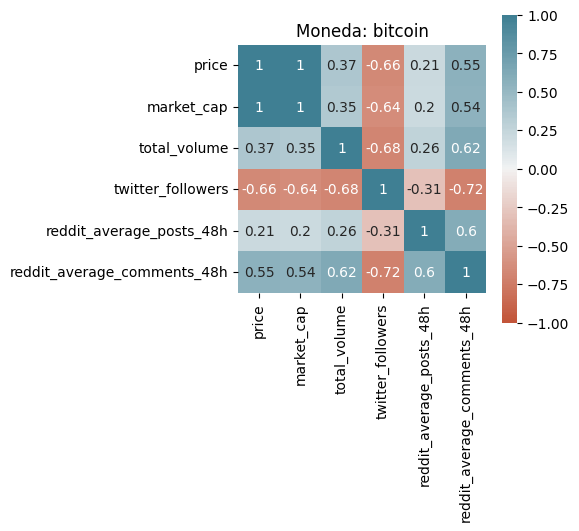

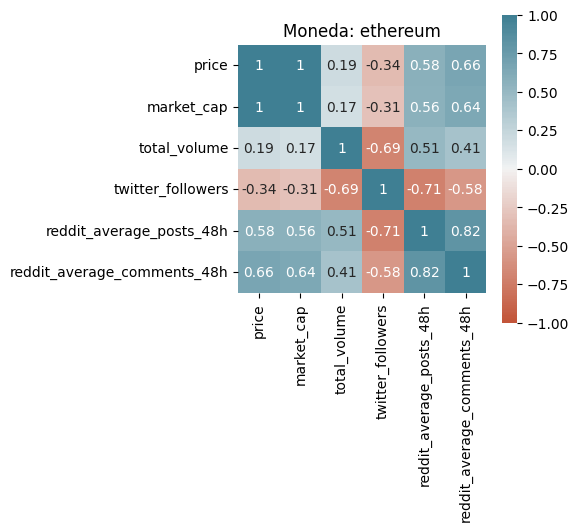

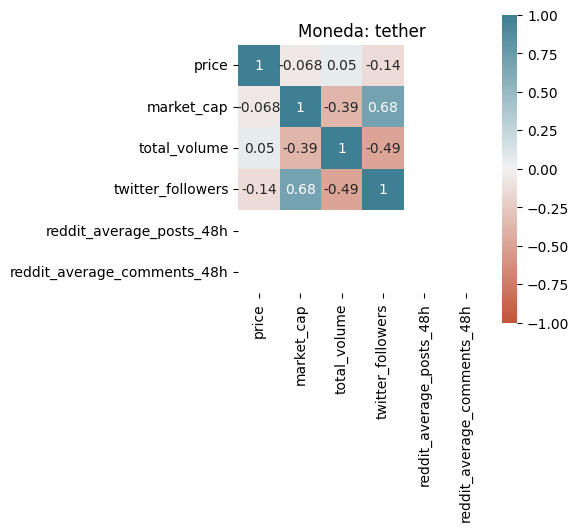

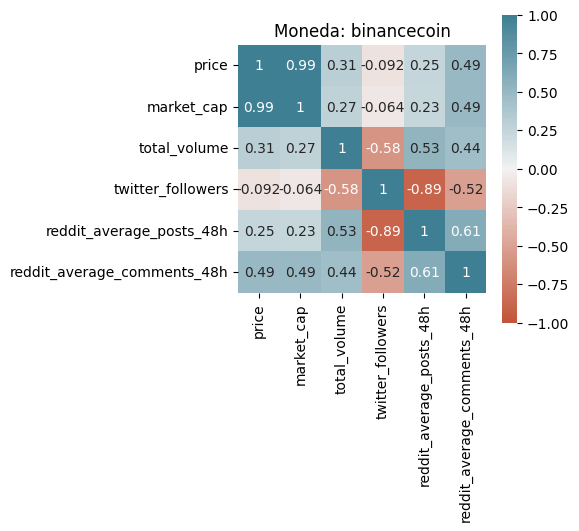

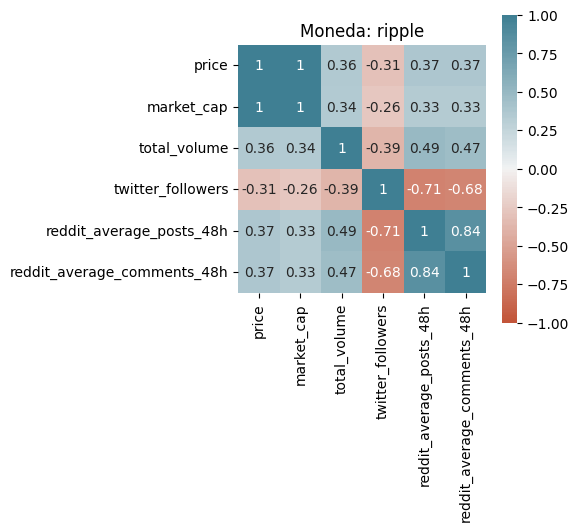

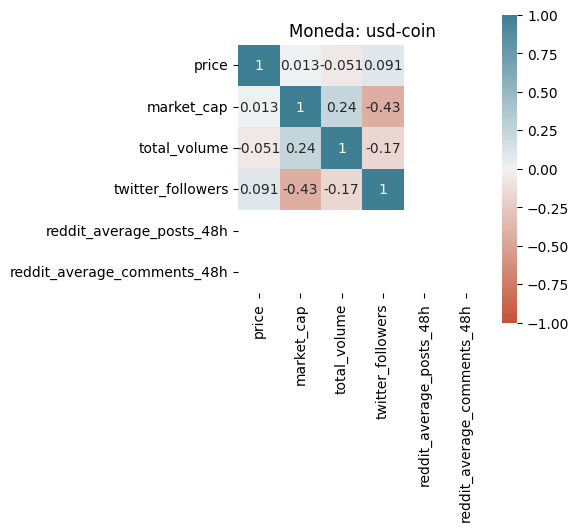

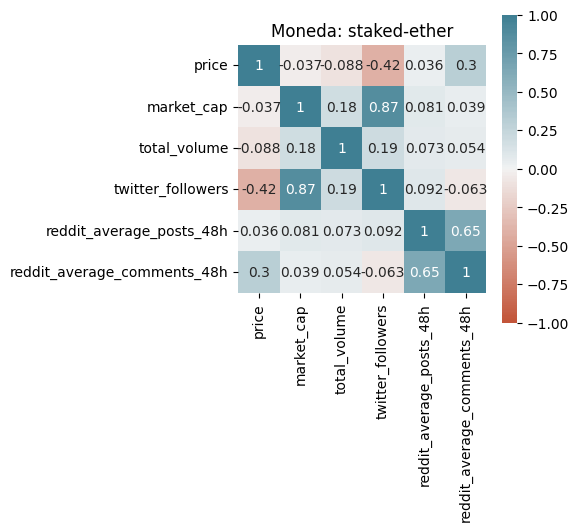

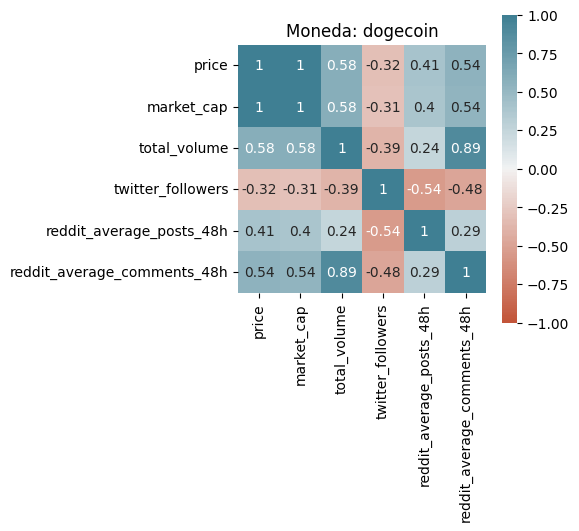

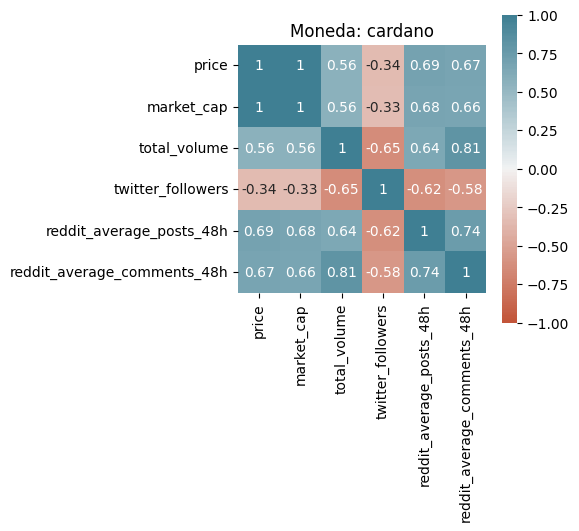

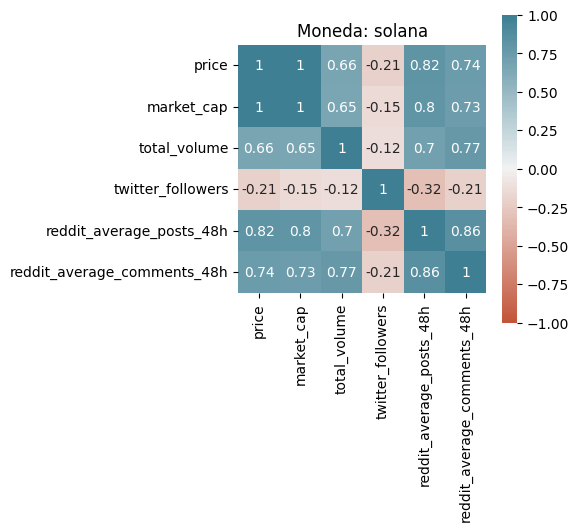

In [98]:
for coin in coinIds:
    corr_matrix = reduced_df[reduced_df['id'] == coin].drop(columns=['id', 'date']).corr()
    fig = plt.figure(figsize=(4,4))
    ax = sns.heatmap(
        corr_matrix, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True
    )
    ax.set_title(f"Moneda: {coin}")

Mirando la correlacion entre el precio y el resto de las variables, aparentemente `solana` y `cardano` tienen bastante correlacion con lo que sucede en reddit.

En un poco de menor medida `ethereum` y `dogecoin` tambien tienen algo de relacion con reddit.

---
# Exportar data Limpia

In [99]:
reduced_df.to_csv("datasets/cleaned_coins_data.csv")